<a href="https://colab.research.google.com/github/amey1234444/AgentLaboratory/blob/main/CircularFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import csv

In [ ]:
import pandas as pd

def getSize(fileName):
    # Read CSV file
    dataFrame = pd.read_csv(fileName)

    # Clean column names (remove spaces and tab characters)
    dataFrame.columns = dataFrame.columns.str.strip().str.replace(r'\t', '', regex=True)

    # Extract trader IDs
    traderList = list(dataFrame['SELL_TRADER_ID'])
    traderList.extend(list(dataFrame['BUY_TRADER_ID']))

    # Convert to set to get unique trader IDs
    traderSet = set(traderList)
    traderSize = len(traderSet)

    return traderSize


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np

def getSize(fileName):
    dataFrame = pd.read_csv(fileName)
    dataFrame.columns = dataFrame.columns.str.strip().str.replace(r'\t', '', regex=True)

    # Find max trader ID instead of count of unique traders
    max_trader_id = max(dataFrame['SELL_TRADER_ID'].max(), dataFrame['BUY_TRADER_ID'].max())

    return max_trader_id  # Ensure array size matches max ID

def getUndirectedGraph(fileName):
    # Read CSV file
    dataFrame = pd.read_csv(fileName)

    # Clean column names (remove spaces and tabs)
    dataFrame.columns = dataFrame.columns.str.strip().str.replace(r'\t', '', regex=True)

    print(dataFrame.columns)  # Debugging: Check cleaned column names

    # Use max trader ID as nodeSize
    nodeSize = getSize(fileName)

    # Initialize an undirected graph
    myGraph = nx.Graph()

    # Add nodes to the graph
    myGraph.add_nodes_from(list(range(1, nodeSize + 1)))

    # Initialize lists
    buyer = []
    seller = []
    trader = []

    # Extract seller and buyer IDs
    for ind in dataFrame.index:
        u = dataFrame['SELL_TRADER_ID'][ind]  # Fixed column name
        v = dataFrame['BUY_TRADER_ID'][ind]   # Fixed column name
        seller.append(u)
        buyer.append(v)

    # Initialize presence arrays with correct size
    vSeller = np.zeros(nodeSize + 1, dtype=int)
    vBuyer = np.zeros(nodeSize + 1, dtype=int)

    for x in seller:
        if x < len(vSeller):  # Avoid index error
            vSeller[x] = 1
    for x in buyer:
        if x < len(vBuyer):  # Avoid index error
            vBuyer[x] = 1

    # Adding edges with weights
    for ind in dataFrame.index:
        u = dataFrame['SELL_TRADER_ID'][ind]
        v = dataFrame['BUY_TRADER_ID'][ind]
        w = dataFrame['TRADE_RATE'][ind]

        # Ensure both are traders and u != v
        if (u < len(vSeller) and v < len(vBuyer) and
            vSeller[u] == 1 and vBuyer[u] == 1 and
            vSeller[v] == 1 and vBuyer[v] == 1 and (u != v)):

            trader.append(u)
            trader.append(v)

            # If edge exists, update weight; otherwise, add a new edge
            if myGraph.has_edge(u, v):
                myGraph[u][v]['weight'] += w
            else:
                myGraph.add_edge(u, v, weight=w)

    return myGraph, list(set(trader))

# Run function
undirectedGraph, nodeSet = getUndirectedGraph('/content/Trades.csv')



Index(['TRADE_SEQUENCE', 'TRADE_NUMBER', 'TRADE_TIME', 'TRADE_DATE',
       'SCRIP_CODE', 'BUY_MEMBER_CODE', 'SELL_MEMBER_CODE', 'BUY_CLIENT_ID',
       'SELL_CLIENT_ID', 'BUY_ORDER_ID', 'SELL_ORDER_ID', 'BUY_TRADER_ID',
       'SELL_TRADER_ID', 'TRADE_QUANTITY', 'TRADE_RATE', 'TRADE_VALUE',
       'BUY_LOCATION_ID', 'SELL_LOCATION_ID', 'BUY_TIMESTAMP',
       'SELL_TIMESTAMP'],
      dtype='object')


In [ ]:
nodeSize = getSize('/content/Trades.csv')
undirectedDict = {}
for node in range(1, nodeSize+1):
    neighbors = undirectedGraph[node].items()
    neighborList = [x[0] for x in neighbors]
    undirectedDict[node] = neighborList
w = csv.writer(open("Undirected_Graph.csv", "w"))
for key, val in undirectedDict.items():
    w.writerow([key, val])

In [ ]:
def getDirectedGraph(fileName):
    # Load CSV and clean column names
    dataFrame = pd.read_csv(fileName, delimiter=',')
    dataFrame.columns = dataFrame.columns.str.strip()  # Remove leading/trailing spaces

    print("Column Names After Cleaning:", dataFrame.columns.tolist())  # Debugging

    nodeSize = getSize(fileName)
    myGraph = nx.DiGraph()

    # Add nodes to the Graph
    # myGraph.add_nodes_from(range(1, int(nodeSize) + 1))
    myGraph.add_nodes_from(list(range(1, int(nodeSize)+1)))

    # Adding edges with weights to the Graph
    for ind in dataFrame.index:
        u = dataFrame['SELL_TRADER_ID'][ind]
        v = dataFrame['BUY_TRADER_ID'][ind]
        w = dataFrame['TRADE_RATE'][ind]

        if u in myGraph[v]:  # Check if edge exists
            myGraph[v][u]['weight'] += w
        else:
            myGraph.add_edge(v, u, weight=w)

    return myGraph

# Run the function
DirectedGraph = getDirectedGraph('/content/Trades.csv')

Column Names After Cleaning: ['TRADE_SEQUENCE', 'TRADE_NUMBER', 'TRADE_TIME', 'TRADE_DATE', 'SCRIP_CODE', 'BUY_MEMBER_CODE', 'SELL_MEMBER_CODE', 'BUY_CLIENT_ID', 'SELL_CLIENT_ID', 'BUY_ORDER_ID', 'SELL_ORDER_ID', 'BUY_TRADER_ID', 'SELL_TRADER_ID', 'TRADE_QUANTITY', 'TRADE_RATE', 'TRADE_VALUE', 'BUY_LOCATION_ID', 'SELL_LOCATION_ID', 'BUY_TIMESTAMP', 'SELL_TIMESTAMP']


In [ ]:

def kNear(graph, nodeSet, K):
    Dict = {}
    for node in nodeSet:
        neighbors = np.array(sorted(graph[node].items(), key=lambda e: e[1]["weight"], reverse=True))
        if(neighbors.shape[0]<K):
            neighborList = [x[0] for x in neighbors]
        else :
            neighbors = neighbors[:K]
            neighborList = [x[0] for x in neighbors]
        Dict[node]=neighborList
    return Dict

knnGraph = kNear(undirectedGraph, nodeSet, 6)

In [ ]:
print(knnGraph);

{1: [201, 202, 203, 204, 207, 205], 2: [201, 203, 202, 204, 205, 207], 3: [201, 202, 203, 204, 205, 207], 4: [201, 202, 203, 205, 204, 207], 5: [201, 203, 202, 204, 207, 205], 6: [201, 202, 203, 204, 207, 205], 7: [201, 203, 202, 204, 207, 205], 8: [201, 202, 203, 204, 205, 207], 9: [201, 202, 203, 204, 207, 205], 10: [201, 203, 202, 204, 207, 205], 11: [201, 202, 203, 204, 205, 207], 12: [201, 203, 202, 207, 204, 205], 13: [201, 202, 203, 204, 205, 207], 14: [201, 202, 203, 204, 207, 205], 15: [201, 203, 202, 204, 207, 205], 16: [201, 202, 203, 204, 205, 207], 17: [201, 203, 202, 204, 205, 2], 18: [201, 202, 204, 203, 205, 207], 19: [201, 203, 205, 202, 204, 206], 20: [201, 203, 202, 205, 204, 207], 21: [201, 203, 202, 204, 207, 205], 22: [201, 203, 202, 204, 205, 207], 23: [201, 203, 202, 204, 207, 205], 24: [201, 202, 203, 204, 207, 206], 25: [201, 203, 204, 202, 205, 207], 26: [201, 203, 202, 204, 207, 205], 27: [201, 203, 204, 202, 207, 205], 28: [201, 203, 202, 204, 207, 205], 29

In [ ]:
nodeSize = getSize('/content/Trades.csv')
clusterId = np.array(list(range(nodeSize+1)))
clusterSize = np.ones(nodeSize, dtype = int)
def parent(u):
    while clusterId[u]!=u:
        u = clusterId[u]
    return u
def common(u, v):
    neighborU = knnGraph[u]
    neighborV = knnGraph[v]
    return len(list(set(neighborU)&set(neighborV)))
def union(u, v):
    x = parent(u)
    y = parent(v)
    global clusterId
    global clusterSize
    if clusterSize[x]>clusterSize[y]:
        clusterId[y] = x
        clusterSize[x]+=clusterSize[y]
    else :
        clusterId[x] = y
        clusterSize[y]+=clusterSize[x]

In [ ]:
kt = 2
for u in nodeSet:
    for v in nodeSet:
        x = parent(u)
        y = parent(v)
        if x!= y :
            if (u in knnGraph[v]) and (v in knnGraph[u]):
                if common(u,v)>=kt:
                    union(u,v)

In [ ]:
SNNClust = {}
vis = np.zeros(nodeSize+1, dtype = int)
for node in range(1, nodeSize+1):
    currId = parent(node)
    if vis[currId]==0:
        SNNClust[currId]=[node]
    else:
        SNNClust[currId].append(node)
    vis[currId] = 1

In [ ]:
SNNDict = {}
for x in SNNClust:
    if len(SNNClust[x])>2:
        SNNDict[x]=SNNClust[x]

In [ ]:
w = csv.writer(open("Shared_Nearest_Neighbor.csv", "w"))
for key, val in SNNDict.items():
    w.writerow([key, val])

In [ ]:
import matplotlib.pyplot as plt

path ='SNNResult/Cluster'
cnt = 1
for clusterId in SNNDict:
    tempGraph = nx.Graph()
    for u in SNNDict[clusterId]:
        for v in SNNDict[clusterId]:
            if u!=v and undirectedGraph.has_edge(u,v):
                tempGraph.add_edge(u,v)
    nx.draw(tempGraph, with_labels=True, node_size=1500, node_color = 'y',font_weight='bold')
    plt.savefig(path+str(cnt))
    plt.clf()
    cnt+=1

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import os # Import the os module

path ='SNNResult/Cluster'
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(path), exist_ok=True)

cnt = 1
for clusterId in SNNDict:
    tempGraph = nx.Graph()
    for u in SNNDict[clusterId]:
        for v in SNNDict[clusterId]:
            if u!=v and undirectedGraph.has_edge(u,v):
                tempGraph.add_edge(u,v)
    nx.draw(tempGraph, with_labels=True, node_size=1500, node_color = 'y',font_weight='bold')
    plt.savefig(path+str(cnt)) # Now this should work
    plt.clf()
    cnt+=1

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display

def drawGraph(tempGraph, path, cnt):
    # ✅ Create directory if it doesn’t exist
    os.makedirs(path, exist_ok=True)

    # ✅ Draw the graph
    nx.draw(tempGraph, with_labels=True, node_size=1500, node_color='y', font_weight='bold')

    # ✅ Save the image
    image_path = os.path.join(path, f"Cluster{cnt}.png")
    plt.savefig(image_path)

    # ✅ Show the image in Jupyter Notebook
    plt.show()

    # ✅ Clear figure to avoid overlapping
    plt.clf()

    # ✅ Display saved image
    display(Image(image_path))


In [ ]:
def virtualGraph(fileName, Dict):
    dataFrame = pd.read_csv(fileName, delimiter =',')
    dataFrame.columns = dataFrame.columns.str.strip().str.replace(r'\t', '', regex=True)
    nodeSize = getSize(fileName)
    vis = np.zeros(nodeSize+1, dtype= int)
    mark= np.zeros(nodeSize+1, dtype = int)
#     creation of virtual Graph
    vGraph = nx.DiGraph()
    vGraph.add_nodes_from(list(range(1, nodeSize+1)))
    nodeList = []
# adding nodes of the SNNDict
    for clusterId in Dict:
        for node in Dict[clusterId]:
            vis[node] = 1
            mark[node] = 1
#  adding nodes which have either of them visited
    cnt = 0
    for ind in dataFrame.index:
        u = dataFrame['SELL_TRADER_ID'][ind]
        v = dataFrame['BUY_TRADER_ID'][ind]
        w = dataFrame['TRADE_RATE'][ind]
        if ((vis[u]==1) or (vis[v]==1)):
            if (mark[u]==0) or (mark[v]==0):
                cnt+=1
            mark[u] = 1
            mark[v] = 1
            if u in list(vGraph.adj[v]):
                vGraph[v][u]['weight']+=w
            else :
                vGraph.add_edge(v, u, weight = w)
    for i in range(1, nodeSize+1):
        if mark[i]==0:
            vGraph.remove_node(i)
        else :
            nodeList.append(i)
    return (nodeList, vGraph)

In [ ]:
(vNodeList, vGraph) = virtualGraph('/content/Trades.csv', SNNDict)

In [ ]:
print("vNodeList--->>" , vNodeList);

vNodeList--->> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [ ]:
print("vGraph--->>" , vGraph);

vGraph--->> DiGraph with 547 nodes and 6379 edges


In [ ]:
vdirectedDict = {}
for node in vNodeList:
    neighbors = vGraph[node].items()
    neighborList = [x[0] for x in neighbors]
    vdirectedDict[node] = neighborList
w = csv.writer(open("vdirected_Graph.csv", "w"))
for key, val in vdirectedDict.items():
    w.writerow([key, val])

In [ ]:
knnGraph = kNear(vGraph, vNodeList, 6)
DictofClusters = {}
for i in vNodeList:
    DictofClusters[i] = [i]

In [ ]:
def mnvForNodes(u, v):
    listU = knnGraph[u]
    listV = knnGraph[v]
    rankOfVinU = 100
    rankOfUinV = 100

    for i in range(len(listU)):
        if listU[i]==v:
            rankOfVinU = i+1
            break

    for i in range(len(listV)):
        if listV[i]==u:
            rankOfUinV = i+1
            break

    return rankOfUinV+rankOfVinU


In [ ]:
def mnvForClusters(c1, c2):
    cluster1 = DictofClusters[c1]
    cluster2 = DictofClusters[c2]
    s = 0
    for u in cluster1:
        for v in cluster2:
            val = mnvForNodes(u, v)
            s = s + val
    length = len(cluster1) * len(cluster2)
    return s/length

In [ ]:
mnvSet = set()

# Identify the minimum node value (mnv) for each cluster pair and store in a set
for cluster_a in vNodeList:
    for cluster_b in vNodeList:
        if cluster_a != cluster_b:
            min_node_value = mnvForClusters(cluster_a, cluster_b)
            mnvSet.add((min_node_value, cluster_a, cluster_b))


In [ ]:
def mutual_nn_neighbour(target_clusters, max_mnv):
    global DictofClusters, mnvSet
    current_cluster_count = len(DictofClusters)

    # Continue merging clusters until the desired count is reached
    iteration = 0
    while current_cluster_count > target_clusters:
        # Find the cluster pair with the minimum MNV
        min_cluster = min(mnvSet)

        # Stop merging if the smallest MNV exceeds the allowed threshold
        if min_cluster[0] > max_mnv:
            break

        cluster_a, cluster_b = min_cluster[1], min_cluster[2]
        clusters_to_merge = [cluster_a, cluster_b]

        # Remove all entries involving either cluster_a or cluster_b from mnvSet
        for existing_cluster in DictofClusters:
            for merging_cluster in clusters_to_merge:
                value = mnvForClusters(existing_cluster, merging_cluster)
                mnvSet.discard((value, existing_cluster, merging_cluster))
                mnvSet.discard((value, merging_cluster, existing_cluster))

        # Merge cluster_b into cluster_a and delete cluster_b
        DictofClusters[cluster_a].extend(DictofClusters[cluster_b])
        del DictofClusters[cluster_b]

        # Recalculate MNV values for the new merged cluster
        for existing_cluster in DictofClusters:
            if existing_cluster != cluster_a:
                new_mnv = mnvForClusters(existing_cluster, cluster_a)
                mnvSet.add((new_mnv, existing_cluster, cluster_a))

        print(f"Iteration {iteration + 1} completed: {current_cluster_count} → {target_clusters}")

        iteration += 1
        current_cluster_count -= 1


In [ ]:
print(f"Initial number of clusters: {len(vNodeList)}")
mutual_nn_neighbour(target_clusters=len(vNodeList) - 500, max_mnv=150)


Initial number of clusters: 547
Iteration 1 completed: 547 → 47
Iteration 2 completed: 546 → 47
Iteration 3 completed: 545 → 47
Iteration 4 completed: 544 → 47
Iteration 5 completed: 543 → 47
Iteration 6 completed: 542 → 47
Iteration 7 completed: 541 → 47
Iteration 8 completed: 540 → 47
Iteration 9 completed: 539 → 47
Iteration 10 completed: 538 → 47
Iteration 11 completed: 537 → 47
Iteration 12 completed: 536 → 47


In [ ]:
mnn_clusters = {cluster_id: nodes for cluster_id, nodes in DictofClusters.items() if len(nodes) > 2}

# Save Mutual Nearest Neighbor clusters to a CSV file
with open("Mutual_Nearest_Neighbor.csv", "w", newline="") as file:
    writer = csv.writer(file)
    for cluster_id, nodes in mnn_clusters.items():
        writer.writerow([cluster_id, nodes])


FileNotFoundError: [Errno 2] No such file or directory: 'MNNResult/Cluster1.png'

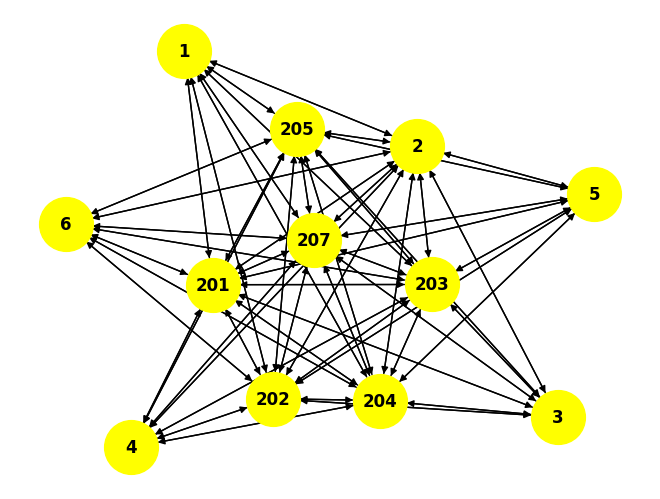

In [ ]:
output_path = 'MNNResult/Cluster'
cluster_index = 1

for cluster_id, nodes in mnn_clusters.items():
    temp_graph = nx.DiGraph()
    for node_u in nodes:
        for node_v in nodes:
            if node_u != node_v and vGraph.has_edge(node_u, node_v):
                temp_graph.add_edge(node_u, node_v)

    nx.draw(temp_graph, with_labels=True, node_size=1500, node_color='yellow', font_weight='bold')
    plt.savefig(f"{output_path}{cluster_index}.png")
    plt.clf()
    cluster_index += 1

# Display dataset size
print(getSize('/content/Trades.csv'))


In [ ]:
print(getSize('/content/Trades.csv'))
